In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, MultiHeadAttention, Add, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

In [2]:
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [3]:
# charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../Facenet Embeddings/Train/X_train.npy'
path_val = '../../../Facenet Embeddings/Val/X_val.npy'
path_test = '../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)
## if in the first or second position exists a 1, then y is 0 and only has a shape of 1, else 1
##y_train = np.where((y_train[:, 3] == 1), 1, 0).reshape(-1, 1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)
##y_val = np.where((y_val[:, 3] == 1), 1, 0).reshape(-1, 1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

#y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
##y_test = np.where((y_test[:, 3] == 1), 1, 0).reshape(-1, 1)

X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [4]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5711, 5, 128), (1428, 5, 128), (1785, 5, 128), (5711,), (1428,), (1785,))

In [5]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [6]:
# Parámetros
n_models = 1
models = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    x = LayerNormalization()(inputs)

    # Stacked Transformer Encoders (puedes ajustar la cantidad)
    for _ in range(3):  # Usa 2 o 3 para más capacidad
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model

# Creamos y entrenamos el modelo
model = build_transformer_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.2789 - loss: 1.6454 - val_accuracy: 0.2969 - val_loss: 1.3849 - learning_rate: 1.0000e-04
Epoch 2/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2718 - loss: 1.3154 - val_accuracy: 0.2500 - val_loss: 1.4329 - learning_rate: 1.0000e-04
Epoch 3/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2661 - loss: 1.3250 - val_accuracy: 0.3186 - val_loss: 1.3080 - learning_rate: 1.0000e-04
Epoch 4/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2819 - loss: 1.3866 - val_accuracy: 0.2899 - val_loss: 1.3225 - learning_rate: 1.0000e-04
Epoch 5/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3041 - loss: 1.2359 - val_accuracy: 0.2374 - val_loss: 1.4329 - learning_rate: 1.0000e-04
Epoch 6/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2840 - loss: 1.2881 - val_accuracy: 0.3739 - val_loss: 1.2327 - learning_rate: 1.0000e-04
Epoch 7/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/ste

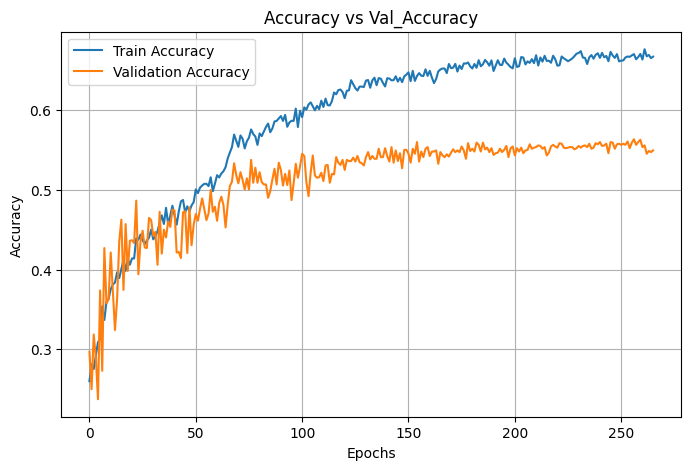

In [12]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

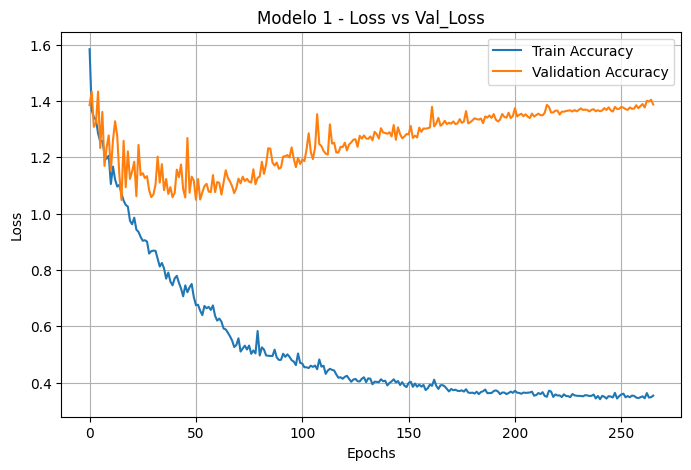

In [13]:
# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title(f'Modelo {1} - Loss vs Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


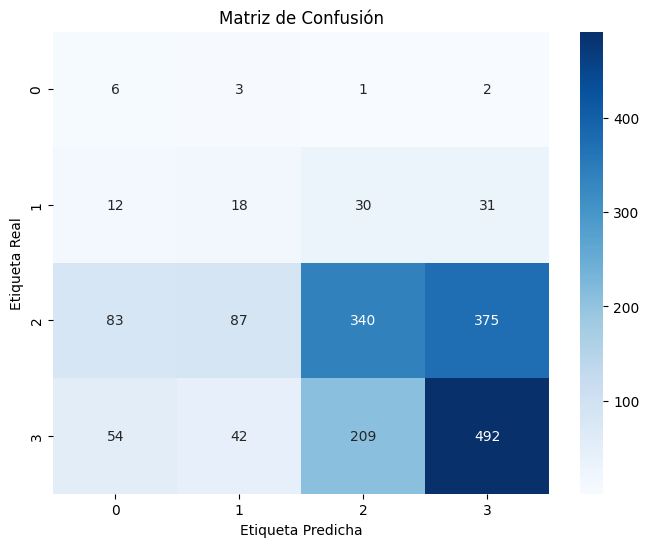

In [15]:
# 5 LR
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [16]:
# Classification report 5 LR
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.039     0.500     0.072        12
           1      0.120     0.198     0.149        91
           2      0.586     0.384     0.464       885
           3      0.547     0.617     0.580       797

    accuracy                          0.480      1785
   macro avg      0.323     0.425     0.316      1785
weighted avg      0.541     0.480     0.497      1785

